# 6 Point ODMR Analsysis

This script is used to analyse the 6 point ODMR scan (and hopefully will be general enough for 11 point ODMR) data. 

The data contained within the .dat file contains the fluorescence intensity recorded from a nanodiamond (cluster) while 6 (or 11) microwave frequnecies are applied to the sample. The frequencies are chosen to be around the resonant frequnecy of the NV centre. 

This program works by: 
1. First loading in the CW ODMR measurement from which the 6 point ODMR microwave frequnecies were determined. 
1. The data is then averaged to give a singal line scan, the ODMR scan is then normalised about its off-resonant fluorescnt signal. 
1. The Lorentz fitting is then generated for the mean ODMR values. 
1. A plot is then made from these values. 
1. The 6 point ODMR data is then loaded in, as is the frequnecy list used for the 6 point ODMR measurement. 
1. The 6 point ODMR curve data set has 11 points per applied frequnecy. So the mean and the standard deviation of these data points will be calculated. This will give a 2D dataset with 
1. From this point, I will generate a graph that has: 
    1. The fitted Lorentzian lineshape for the ODMR curve. 
    1. The CW ODMR values that correspond to the 6 frequency points used in the 6 point ODMR curve. 
    1. The normalised 6 point ODMR dataset fluorescent values plus their standard deviation. 
1. I will calculate the difference between the CW ODMR value and the 6 point ODMR value for the applied frequnecies. Hopefully any variation will be small, consistent across all the frequnecies and be smaller than the standard deviation of the 6 point ODMR scan. 

In [1]:
import numpy as np 
import scipy.optimize as opt 
import matplotlib.pyplot as plot 
import os 
import pandas as pd

In [2]:
def load_data(file_path):
    '''Downloads the data from a .dat file and saves it into a numpy array.'''
    data_array = np.loadtxt(file_path)
    return(data_array)

In [3]:
def load_params(file_path):
    '''load in the params data.''' 
    params_data = pd.read_table(file_path, names = ['Parameter name', 'Parameter value']) 
    return(params_data)

In [4]:
def create_freq_scan(start, stop, step_size):
    '''takes the scan parameters from the params data file. '''
    step_size_GHz = step_size/1000
    number_of_steps = int((stop-start)/step_size_GHz)+1
    freq = np.linspace(start, stop, number_of_steps)
    
    return(freq)

In [5]:
def set_plot_params():
    '''formats the plot parameters '''
    plot.rcParams.update({'font.size' : 20})
    plot.rcParams.update({'figure.figsize' :[12, 8]})

In [6]:
def mean_data(odmr_data):
    '''find the mean of the data '''
    mean_odmr_data =  np.mean(odmr_data, axis=0)
    return(mean_odmr_data)

In [7]:
def normalise_data(mean_odmr_data):
    ''' normalise the data to the maximum value of the mean dataset.''' 
    norm_odmr_data = mean_odmr_data/(np.mean(mean_odmr_data[0:50]))
    return(norm_odmr_data)

In [8]:
def scatter_plot(freq,mean_data):
    '''Creates a scatter plot for experimental data.''' 
    fig2, ax2 = plot.subplots()
    ax2.scatter(freq, mean_data, marker = 'x',color = 'r', label = "ODMR Data")
    ax2.set_xlim(np.min(freq),np.max(freq))
    return(fig2, ax2)

In [9]:
def get_init_params(odmr_data, freq):
    ''' find the minima of the ODMR spectra and ODMR dip contrast and 
    flourenscent baseline.'''
    
    half_data_length = int((len(freq)-1)/2) - 5 # This brings the mid-value to 2.87GHz 
    
    # find the indices for the lowest frequency value
    low_freq_min_index = np.where(odmr_data[0:half_data_length] == np.min(odmr_data[0:half_data_length]))
    high_freq_min_index = np.where(odmr_data[half_data_length:len(odmr_data)-1] == 
                                   np.min(odmr_data[half_data_length:len(odmr_data)-1]))
   
    # frequencies corresponding to ODMR minima
    freq_mins = [np.float(freq[low_freq_min_index[0]]),
                 np.float(freq[high_freq_min_index[0]+half_data_length])]
    
    # manually set frequencies. 
    
    #freq_mins = [2.78, 2.96]
    
    flourescent_baseline = np.mean(odmr_data)
    
    # approximate dip_depth
    dip_depth = [odmr_data[low_freq_min_index[0][0]]  - flourescent_baseline, 
                 odmr_data[high_freq_min_index[0][0]+half_data_length]  - flourescent_baseline]
    
    #contrast = [np.float((1-odmr_data[low_freq_min_index[0]]/flourescent_baseline)), 
    #            np.float((1-odmr_data[high_freq_min_index[0]+half_data_length]/flourescent_baseline))]

    return(freq_mins, dip_depth, flourescent_baseline)

In [10]:
def optimised_lorentz_fit(freq, mean_data, init_params, lower_bounds, upper_bounds):
    '''A method to find the fitting prameters for the ODMR dataset.''' 
    y_error = np.sqrt(mean_data) # poissonian noise
    coeffs, confidence = opt.curve_fit(double_lorentz, freq, mean_data, init_params, 
                                       sigma = y_error, bounds = (lower_bounds, upper_bounds))
    opt_error = np.sqrt(np.diag(confidence))
    
    return(coeffs, opt_error)

In [11]:
def double_lorentz(x, A1, X01, sig1, A2, X02, sig2, offset): #P0[0], P0[1], P0[2], P0[3], P0[4], P0[5], P0[6]):
    ''' A1 = Amplitude 1, X01 = Resonance 1, sig1 = FWHM 1
     A2 = Amplitude 2, X02 = Resonance 2, sig2 = FWHM 2, offset = offset'''
    
    first_peak = (A1/np.pi)*((sig1**2)/(sig1**2 +(2*x-2*X01)**2))
    second_peak = (A2/np.pi)*((sig2**2)/(sig2**2 +(2*x-2*X02)**2))
    
    return (first_peak + second_peak + offset)

In [25]:
def plot_fitting(ax2, freq, fitting_params):
    ''' plot the y fit. '''
    
    high_res_freq = np.linspace(freq[0], freq[len(freq)-1], 1000*len(freq)+1)
    # create the double lorentz fit array
    y_fit_high_res = double_lorentz(high_res_freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])
    
    y_fit = double_lorentz(freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])
    
    ax2.plot(high_res_freq, y_fit_high_res, color='k', label='Double Lorentz \nfitting')
    ax2.legend()
    ax2.set_xlabel('Microwave Frequency (GHz)', fontsize = 18)
    ax2.set_ylabel('Normalised Counts', fontsize = 18)
    
    return(ax2, y_fit, high_res_freq, y_fit_high_res)
 

In [40]:
def get_r_squared(y_data, y_fitting):
    '''This is a function used to generate the goodness of fit metric r^2.
    This value will be used to judge the effectiveness of the curve fitting 
    used to find the resonant frequencies of the NV centre.'''
    
    y_data_mean = np.mean(y_data)
    SStot = np.sum((y_data - y_data_mean)**2) # Find the variation in experimental y values.
    SSres = np.sum((y_data - y_fitting)**2) # Find the variation betweem the experimental and fitted y values. 
    
    r_squared = 1 - (SSres/SStot) # Calculate R^2
    
    return(r_squared)

In the below cell, I run the code that is required to retrieve the ODMR data from a .dat file, find the mean fluorescence intensity value for each applied frequnecy and normalise the whole mean linescan to the off-resonant signal. 

These values are plotted and a double lorentzian curve fit for the data generated and plotted on the same graph. 

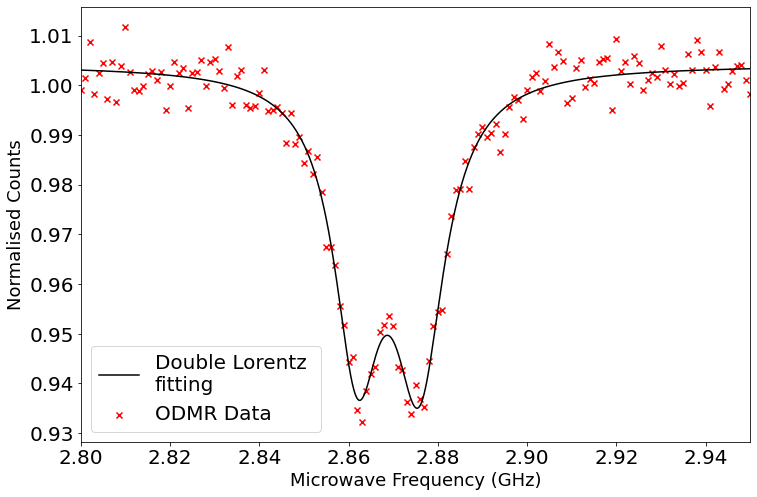

In [56]:
'''######
 # This portion of the code produced the ODMR data plotting and the double lorentz fitting and 
 # Saves this data into a text file and the 2 plots generated. 
#######'''

# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.
folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\'
date = '20210315'
file_name = date + '_NVScan_01'
nd_number = int(file_name[-2:]) - 1
#nd = np.remainder(nd_number, 5) + 1

#print(nd)

odmr_data = load_data(folder_path + date + '\\' + file_name + '.dat')
params_file = load_params(folder_path + date + '\\' + file_name + 'Params.dat')
params_values = params_file['Parameter value']

# Create the freqeuncy scan array. 
freq = create_freq_scan(params_values[0], params_values[1], params_values[2])

# Set Plot parameters. 
set_plot_params()

# find the mean of the ODMR data
mean_odmr_data = mean_data(odmr_data)

# Normalise the dataset
norm_mean_odmr = normalise_data(mean_odmr_data)
#norm_mean_odmr = mean_odmr_data

# scatter plot of data
fig2, ax2 = scatter_plot(freq, norm_mean_odmr)

# find the freqeuncy points with the highest ODMR contrast
freq_mins, dip_depth, flourescent_baseline = get_init_params(norm_mean_odmr, freq)

# create the initial parameters for ODMR double lorentzian 
# line fitting
init_params = [dip_depth[0], freq_mins[0], 0.005, dip_depth[1], freq_mins[1], 0.005, flourescent_baseline]
#init_params = [dip_depth[0], 2.865, 0.001, dip_depth[1], 2.87, 0.001, flourescent_baseline]

lower_bounds = [-np.inf, init_params[1] - 0.01, 0, -np.inf, init_params[4] - 0.01, 0, 0]
upper_bounds = [np.inf, init_params[1] + 0.01, 1, np.inf, init_params[4] + 0.01, 1, np.inf]

# generate the optimised curve fit parameters. 
fitting_params, error_in_fit = optimised_lorentz_fit(freq, norm_mean_odmr, init_params,
                                                    lower_bounds, upper_bounds)

ax2, y_fit, high_res_freq, y_fit_high_res = plot_fitting(ax2, freq, fitting_params)

From this point on, I will be writing new code that is designed to retrieve the 6 point ODMR data and do all the other things highlighted at the start. 

In [15]:
def num_of_freqs_applied(freq_array):
    '''Here we find out how many different frequencies were used in the 
    measurement and the index at which the frequnecies change.'''
    
    index = [0]
    num_of_freqs = 1
    new_freq = freq_array[0]
    
    for i in range(len(freq_array)):
        if freq_array[i] != new_freq: 
            index.append(i)
            num_of_freqs = num_of_freqs + 1
            new_freq = freq_array[i]
            
    index.append(len(freq_array)-1)
    
    return(num_of_freqs, index)

In [16]:
def collect_8_point_data(six_point_data, num_of_freqs, freq_change_index):
    '''This method takes the 6 point ODMR data, finds the mean fluorescence intensity value for 
    each applied frequnecy and the standard deviation for this mean value.  '''
    
    mean_values = np.empty([num_of_freqs,1])
    std = np.empty([num_of_freqs,1])
    
    x,y = six_point_data.shape
    
    for i in range(num_of_freqs):
        mean_values[i] = np.mean(six_point_data[0:x, freq_change_index[i]:freq_change_index[i+1]])
        std[i] = np.std(six_point_data[0:x, freq_change_index[i]:freq_change_index[i+1]])
        root_error = np.mean(np.sqrt(six_point_data[0:x, freq_change_index[i]:freq_change_index[i+1]]))
        
    return(mean_values, std, root_error)

In [45]:
def find_8_point_freq_index(high_res_freq, six_point_freq): 
    '''The aim of this method is to find the nearest index in the "high_res_freq array
    to the 6 point ODMR frquencies. These indicies will later be used to see how close to the 
    Lorentz fit the 4 data-points in the dip of the ODMR curve are to the expected experimental value.'''
    
    indicies = np.empty([len(six_point_freq)])
    for i in range(len(six_point_freq)):
        a = int(np.abs(high_res_freq - six_point_freq[i]).argmin()) 
        indicies[i] = a 
        
    return(indicies.astype(int))

In [1]:
'''This part of the code is used to retrieve the 6 point ODMR curve data and do stuff with it.'''

# file names for the ODMR data and the frequncy scan data. 
file_name = date + '_6_point_ODMR_12'
frequency_file = '20210315_NVScan_01_6_ODMR_points'

# Get the data from the 6 point scan and the frequency scan. 
eight_point_data = load_data(folder_path + date + '\\' + file_name + '.dat')
eight_point_freq_scan_data =  load_params(folder_path + date + '\\' + frequency_file + '.txt')

eight_point_freq_array = np.array(eight_point_freq_scan_data['Parameter name'])

num_of_freqs, freq_change_index = num_of_freqs_applied(eight_point_freq_array)

eight_point_freqs = eight_point_freq_array[freq_change_index[0:-1]]*10**-9

eight_point_odmr, eight_point_std, root_error = collect_8_point_data(eight_point_data, num_of_freqs, freq_change_index)

# For this scan-type, a reference is recorded after each applied frequnecy. 
# To collapse this data down then to a 4 point scan, each resonant frequnecy meansurement 
# is divided by the reference measurement to give a normalised 4 point scan. 

four_point_intensity = np.zeros([4,1])
for i in range(len(eight_point_odmr)/2):
    four_point_intensity[i,1] =  eight_point_odmr[2*i]/eight_point_odmr[2*i + 1]

#norm_eight_point_odmr = eight_point_odmr/(0.5*(eight_point_odmr[0]+eight_point_odmr[-1]))

#std = (six_point_std/six_point_odmr)

NameError: name 'date' is not defined

In [204]:
root_error = np.array((root_error/np.mean(six_point_odmr))/six_point_data.shape[0])

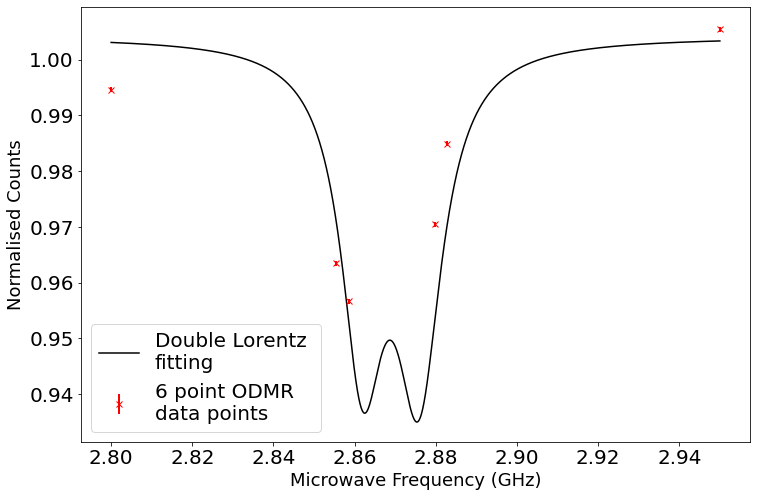

In [205]:
fig1, ax1 = plot.subplots()
ax1, y_fit, high_res_freq, y_fit_high_res  =  plot_fitting(ax1, freq, fitting_params)
ax1.errorbar(six_point_freqs, norm_six_point_odmr, root_error, marker = 'x',
            label = '6 point ODMR \ndata points', linestyle = '', 
            color = 'r', linewidth = 2)

indie = [0]
for i in range(num_of_freqs-1):
    indie.append(int((six_point_freqs[i+1]-six_point_freqs[0])*1000))

#ax1.scatter(freq[indie], norm_mean_odmr[indie], marker = 'o', 
#            label = 'CW ODMR data \nat 6 frequnecies')

ax1.legend(loc = 'lower left')

In [206]:
six_point_index = find_6_point_freq_index(high_res_freq, six_point_freqs)

In [207]:
r_squared = get_r_squared(norm_six_point_odmr[1:4], y_fit_high_res[six_point_index[1:4]])
print(r_squared)

-10.071479128459227


In [208]:
six_point_ODMR_R_squared.append(r_squared)
six_point_intensities.append(norm_six_point_odmr)


In [209]:
print(six_point_ODMR_R_squared, six_point_intensities)

[-10.460746088636213, -12.377780453220891, -11.707830177617806, -6.4136909632532015, -10.071479128459227] [array([[0.99396191],
       [0.95596191],
       [0.95106357],
       [0.96342694],
       [0.98148102],
       [1.00603809]]), array([[0.99209506],
       [0.95834833],
       [0.94984768],
       [0.96074026],
       [0.97720897],
       [1.00790494]]), array([[0.99400181],
       [0.96199402],
       [0.95287387],
       [0.96298798],
       [0.98336227],
       [1.00599819]]), array([[0.98917909],
       [0.96077445],
       [0.94863361],
       [0.96465408],
       [0.98154436],
       [1.01082091]]), array([[0.99457067],
       [0.963496  ],
       [0.95667008],
       [0.97049377],
       [0.98490554],
       [1.00542933]])]


In [174]:
six_point_intensities = []
six_point_ODMR_R_squared = []

In [211]:
mean_6_point_intensity = np.mean(six_point_intensities, axis = 0)
std_six_point_intensity = np.std(six_point_intensities, axis = 0)

In [212]:
print(mean_6_point_intensity)
print(std_six_point_intensity)

[[0.99276171]
 [0.96011494]
 [0.95181776]
 [0.96446061]
 [0.98170043]
 [1.00723829]]
[[0.00197637]
 [0.00267455]
 [0.00280176]
 [0.00327153]
 [0.00257993]
 [0.00197637]]
